In [7]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

import numpy as np
import pandas as pd
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import cross_validation
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.cross_validation import StratifiedKFold

# Cross-Language Rap Detector
A previous project of mine, RapItalia, was designed to approximately track the growth in popularity of rap in Italy, based on the publication date of rap songs that turned up in an Italian lyrics database. Did rap suddenly get popular there 10 years ago? I didn't have any genre information, only lyrical content, and so I made the assertion that rap songs could be distinguished by the number of words in the lyrics. I used a quite arbitrary cutoff for the number of words, specifically 500 words, and verified it only with a quick look at the songs that were identified as rap (I did made sure not to tune it based on the final output of my analysis). The results of this classification were then fed into my subsequent analysis of publication date by genre

Making an assumption like that without evidence is pretty sloppy, so I decided to do better. I did two things:
1. Linked a large body of lyrics with high quality genre information
2. Evaluated whether songs can be correctly classified as rap or non-rap based on non-language-specific properties of the lyrics (like the number of words)

Why non-language-specific? If I train on surface features of rap songs in every language, then I can identify rap songs in every language. This could also shed light generally on the surface-level lyrical differences between genres. And I was curious how far I could get without touching the semantic content. 

First, some helper functions:

In [42]:
def feature_distribution(data, which_feature, xlim=None):
    """Plot a comparison of the distribution of a particular feature between rap and non-rap."""
    
    # Compute the range of feature values to use, if not specified in xlim
    med = np.median(train_data.loc[:,which_feature])
    q75, q25 = np.percentile(train_data.loc[:,which_feature], [75 ,25])
    iqr = q75 - q25
    minx = med-(iqr*2.5)
    if minx < 0:
        minx = 0
    maxx = med+(iqr*2.5)
    if xlim:
        minx=xlim[0]
        maxx=xlim[1]       
    nbins = 20
    bins = np.linspace(minx, maxx, nbins+1) 

    # Plot the histograms
    plt.figure()
    sns.distplot(data.loc[data.is_rap==False,which_feature], bins=bins, label='Non-rap')
    sns.distplot(data.loc[data.is_rap==True,which_feature], bins=bins, label='Rap')
    plt.xlim(minx, maxx)
    plt.title(which_feature)
    plt.legend()
    
def plot_feature_importance(features, fitted_forest):
    """Using a fitted random forest, make a cleveland dot plot of the computed feature importances. """
    plt.figure()
    vals = fitted_forest.feature_importances_
    sortorder = np.flipud(np.argsort(vals))
    features = np.array(features)
    with sns.axes_style("whitegrid"):
        sns.stripplot(y=features[sortorder], x=vals[sortorder], orient="h", color='red', size=10)
    xl = plt.xlim()
    plt.xlim(0,xl[1])
    plt.grid(axis='y',linestyle=':')
    plt.xlabel('Feature importance score')
    
def examine_prediction(y, prediction, data, features, show_misidentified=True):
    """Given a prediction and ground truth (y), output statistics about the quality of the prediction."""
    if type(features) == np.ndarray:
        features = features.tolist()
    
    cm = confusion_matrix(y, prediction)
    np.set_printoptions(precision=2)  
    nonrap_misidentified = float(cm[0,1])/(cm[0,0]+cm[0,1])
    print "Accuracy =\t%.1f%%" % (100*metrics.accuracy_score(y, prediction))
    print "Rap songs correctly identified =\t%.1f%%" % (100*metrics.recall_score(y, prediction))
    print "Songs incorrectly identified as rap =\t%.1f%%" % (100*(1-metrics.precision_score(y, prediction)))
    print "Non-rap songs identified as rap =\t%.1f%%" % (100*nonrap_misidentified)
    print "F1 score =\t%.3f" % metrics.f1_score(y, prediction)
    print('Confusion matrix')
    print(cm)
    if show_misidentified:
        print "Misidentified as rap: "
        display(data.loc[(prediction==1) & (y==0),['artist_name','title']+features])
        print "Misidentified as nonrap: "
        display(data.loc[(prediction==0) & (y==1),['artist_name','title']+features])

def compute_features(lyrics, tdm_indices):
    """Create new superficial lyrics features. Return df with the new features in columns and one row per track."""
    import time
    
    start = time.time()
    total_num_words = np.zeros(len(tdm_indices))
    tdm = lyrics['tdm'].toarray()
    for i in range(len(tdm_indices)):
        total_num_words[i] =  tdm[tdm_indices[i],:].sum()
#    print (time.time()-start)/60

    word_lens = np.array([len(i) for i in lyrics['unstemmed_terms']],dtype=float)
    mean_word_length = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        word_indices = tdm[tdm_indices[i],:].nonzero()[0]
        mean_word_length[i] = np.mean(word_lens[word_indices])
#    print (time.time()-start)/60

    median_word_rank = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        word_indices = tdm[tdm_indices[i],:].nonzero()[0]
        median_word_rank[i] = np.median(word_indices)
#   print (time.time()-start)/60
    
    mean_word_instances = np.zeros(len(tdm_indices))
    for i in range(len(tdm_indices)):
        nums = tdm[tdm_indices[i],:]
        nz = nums[nums.nonzero()]
        mean_word_instances[i] = np.mean(nz)
    mean_word_instances = np.divide(mean_word_instances, total_num_words)
#    print (time.time()-start)/60
    
    additional_features = pd.DataFrame(data={'total_num_words':total_num_words, 'mean_word_length':mean_word_length, 'median_word_rank':median_word_rank, 'mean_word_instances':mean_word_instances})
    return additional_features

## Creating the dataset
My source for lyrics was the [musicXmatch Dataset](http://labrosa.ee.columbia.edu/millionsong/musixmatch), which contains entries for 237,662 songs from the Million Songs Dataset. The MSD is a selection of one million songs based on [loose criteria](http://labrosa.ee.columbia.edu/millionsong/pages/how-did-you-choose-million-tracks) that included as many songs as possible by popular artists, and "extreme" songs in terms of audio characteristics. However the complete lyrics are not included, for copyright reasons:

> The lyrics come in bag-of-words format: each track is described as the word-counts for a dictionary of the top 5,000 words across the set.

This eliminates at least two surface-level properties I was interested in, the line lengths and the occurrence of extremely rare (or made-up) words. But it retains many more. I stored lyrics information in a dict called lyrics, which has at the heart of it a sparse matrix of counts of words (columns) by tracks (rows), sorted in decreasing order of word frequency across the corpus.

```
print lyrics['terms'][0:10]
print(lyrics['tdm'][:5,:].toarray())

['i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not', 'in']
[[10  0 17 ...,  0  0  0]
 [28 15  2 ...,  0  0  0]
 [ 5  4  3 ...,  0  0  0]
 [16  4  0 ...,  0  0  0]
 [39 30 10 ...,  0  0  0]]```


Although the Million Songs Dataset contains a large amount of metadata and data about the acoustic properties of songs (based on data compiled by [The Echo Nest](https://en.wikipedia.org/wiki/The_Echo_Nest), it does not have genre information. I got that from the [tagtraum genre annotations](www.tagtraum.com/msd_genre_datasets.html) to the Million Songs Dataset. It determines genre based on human-generated annotations from the All Music Guide, Last.fm, and the beaTunes Genre Dataset (BGD). There are up to two genres listed for every song, and I defined a track as being rap if it had "Rap" in either of the two genre slots. 

The tagtraum genre annotations covered 133,676 tracks, of which 55,726 intersected with the tracks in the musicXmatch lyrics training set, and 6,967 with the lyrics test set (the musicXmatch dataset has a standard train-test split). `generate_track_info.py` does this merge, and also adds track names and artist names by querying the MSD's sqlite3 database track_metadata.db, and saves the result as pickles.

In [15]:
import pickle

with open('train_track_info.pickle','r') as f:
	track_info = pickle.load(f)
    
with open('train_lyrics_data.pickle','r') as f:
	lyrics = pickle.load(f)

## Feature engineering: Surface text features
Compute new features for each track based on the lyrics.

In [44]:
# Create features
new_features = compute_features(lyrics, track_info.tdm_row)
train_data = pd.concat([track_info, new_features],axis=1)
features = new_features.columns.values

0.236242453257


Examining the distribution of these variables between the two classes shows promising separation of tracks.

`total_num_words` is the number of words in the track, which will be an underestimate of the true number of words because of all words beyond the 5000 most frequent in the lyrics dataset being eliminated. Nevertheless, it should have a very strong linear correlation with the true number of words.

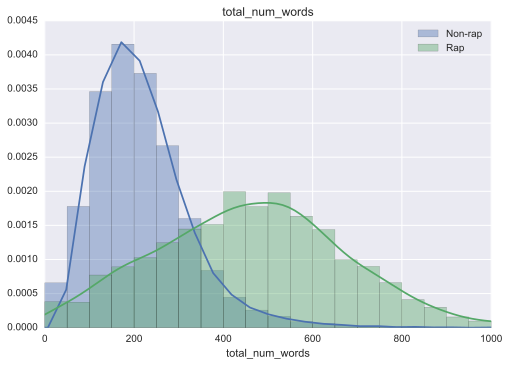

In [51]:
feature_distribution(train_data,'total_num_words',[0,1000])

`mean_word_length` is the mean of the word lengths in a track, not weighting by frequency of the word. Again, not precisely the real values, since the lyrics have been stemmed (although I used the provided unstemming dictionary) but should correlate strongly.

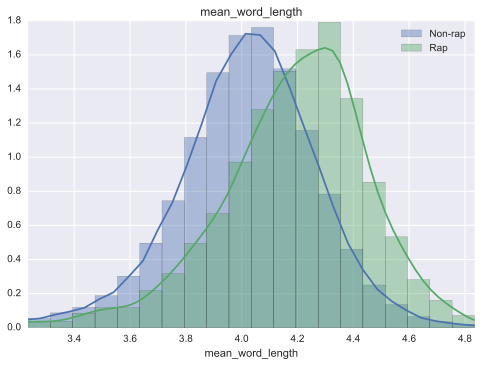

In [52]:
feature_distribution(train_data,'mean_word_length')

`median_word_rank` is the median of the horizontal index of the words in the term-document matrix, which reflects the rarity of the words used.

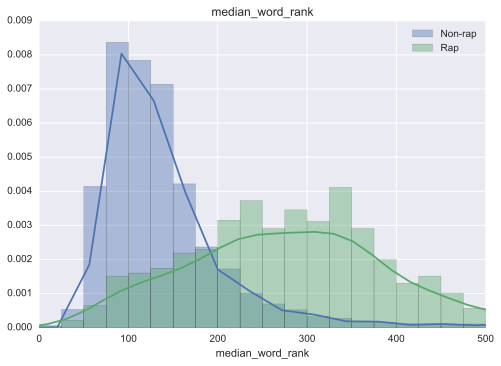

In [53]:
feature_distribution(train_data,'median_word_rank',[0,500])

`mean_word_instances` is the mean number of times a word is repeated in a track, divided by the total number of words in the track. It should reflect how repetitive the song is lyrically (e.g. because of a high ratio of choruses to verses)

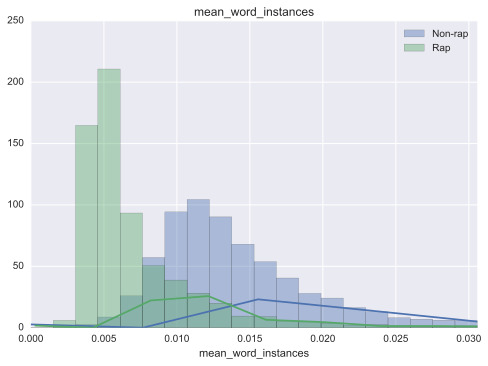

In [54]:
feature_distribution(train_data,'mean_word_instances')

## How I Got to 95% Accuracy Without Really Trying: The Problem of Imbalanced Datasets
All my initial attempts to correctly detect rap songs using the features I created seemed to be very successful: 95% accuracy. But then I realized that this was due to rap songs being much less common than non-rap.

In [55]:
pd.value_counts(track_info.is_rap)

False    53032
True      2694
Name: is_rap, dtype: int64

In fact a dumb model that predicts that no songs will ever be rap achieves this accuracy, thanks to the imbalanced dataset.

In [56]:
# Baseline model: none are rap
prediction = np.zeros(len(train_data))
print "Accuracy = %.1f%%" % (100* np.mean(prediction == train_data.is_rap))

Accuracy = 95.2%


But this was very unsatisfactory for the puposes of my rap detector. I needed a) a better way to measure performance and b) a way to deal with training on this imbalanced data.

## Imbalanced dataset therapy #1: Undersampling the classes to be equal
First, for a metric that is relevant to the performance I care about, which includes correctly identifying rap as well as not incorrectly identifying songs as rap. (aka the recall and 1-the precision). I decided to focus on the F1 score, which combines the two. It correctly measures my rap-doesn't-exist baseline as terrible:

In [57]:
examine_prediction(train_data.is_rap, prediction, train_data, features, show_misidentified=False)

Accuracy =	95.2%
Rap songs correctly identified =	0.0%
Songs incorrectly identified as rap =	100.0%
Non-rap songs identified as rap =	0.0%
F1 score =	0.000
Confusion matrix
[[53032     0]
 [ 2694     0]]


//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


So I equalized the number of non-rap and rap tracks in my training set by selecting a random subset of the non-rap tracks.

In [58]:
# Reduce the number of non-rap training samples so that it is balanced with the rap training samples
num_rap_tracks = np.sum(train_data.is_rap)
non_rap_tracks = train_data.loc[np.invert(train_data.is_rap),:]
rs = cross_validation.ShuffleSplit(len(non_rap_tracks), n_iter=1, test_size=num_rap_tracks,random_state=seed)
sampled_nonrap_tracks =  next(iter(rs))[1]
non_rap_tracks = non_rap_tracks.iloc[sampled_nonrap_tracks,:]
train_data = pd.concat([non_rap_tracks,train_data.loc[train_data.is_rap,:]],ignore_index=True)

y = train_data.loc[:,'is_rap']

print "There are now %d non-rap tracks in the training set" % len(non_rap_tracks)

There are now 2694 non-rap tracks in the training set


### Random Forest cross-validation
With the non-rap and rap tracks equalized, and therefore the chance level of 50%, we can start training classifiers. Here's random forest, which did much better than chance, and also had a good F1 score:

In [59]:
# Prepare for cross validation fittings
num_folds=5
num_instances = len(train_data)
seed = 7
kfold = StratifiedKFold(y, shuffle=True, n_folds=num_folds, random_state=seed)

# Random forest fit
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100)
prediction = cross_validation.cross_val_predict(clf,train_data.loc[:,features], y, cv=kfold)

examine_prediction(y, prediction, train_data, features, show_misidentified=False)

Accuracy =	84.9%
Rap songs correctly identified =	79.5%
Songs incorrectly identified as rap =	10.8%
Non-rap songs identified as rap =	9.7%
F1 score =	0.841
Confusion matrix
[[2434  260]
 [ 551 2143]]


The next few algorithms require the features to be scaled (and I save this scaling so I can apply it to the test data):

In [60]:
scaler = preprocessing.StandardScaler().fit(train_data.loc[:,features])
train_data_scaled = scaler.transform(train_data.loc[:,features])

### Logistic regression cross-validation

The logistic regression fit is almost as good, and much faster.

In [61]:
# Cross validate Logistic regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
prediction = cross_validation.cross_val_predict(clf,train_data_scaled, y, cv=kfold)

examine_prediction(y, prediction, train_data, features, show_misidentified=False)

Accuracy =	83.4%
Rap songs correctly identified =	78.2%
Songs incorrectly identified as rap =	12.7%
Non-rap songs identified as rap =	11.4%
F1 score =	0.825
Confusion matrix
[[2387  307]
 [ 586 2108]]


### Support vector machine cross-validation
The best performance (although probably not statistically significantly better) is from SVM

In [62]:
# Cross validate SVM
from sklearn import svm

clf = svm.SVC()
prediction = cross_validation.cross_val_predict(clf,train_data_scaled, y, cv=kfold)

examine_prediction(y, prediction, train_data, features, show_misidentified=False)

Accuracy =	85.6%
Rap songs correctly identified =	78.4%
Songs incorrectly identified as rap =	8.3%
Non-rap songs identified as rap =	7.1%
F1 score =	0.845
Confusion matrix
[[2503  191]
 [ 583 2111]]


### Choice of number of features and feature importance
We can use [recursive feature elimination with cross-validation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) to see how many features to use, and then by fitting a random forest, rank their importance.

Optimal number of features : 4


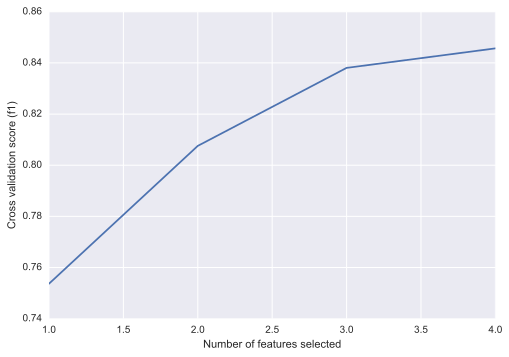

In [63]:
# Recursive feature selection and feature importance
from sklearn.feature_selection import RFECV

#clf = svm.SVC(kernel='linear')
clf = RandomForestClassifier(n_estimators=100)
rfecv = RFECV(estimator=clf, step=1, cv=StratifiedKFold(y, 3, random_state=seed), scoring='f1')
rfecv.fit(train_data_scaled, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (f1)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

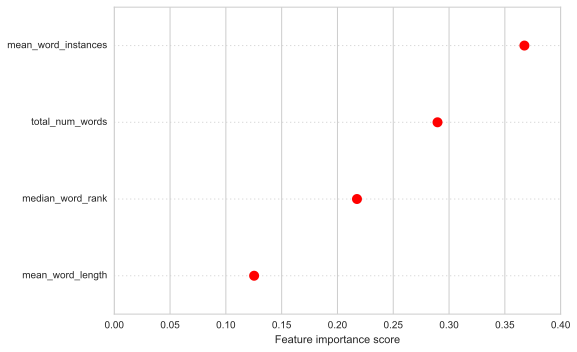

In [64]:
fitted_forest = clf.fit(train_data_scaled, y)
plot_feature_importance(features, fitted_forest)

### Embedding of the points in 2D (t-SNE)
Just to get more insight into the separability of rap and non-rap using our features, I visualized the two classes embedded in 2D space using the [t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

In [65]:
# Compute the t-SNE embedding of the points onto a 2 plane
from sklearn.manifold import TSNE

tsne = TSNE()
proj = tsne.fit_transform(train_data.loc[:,features])

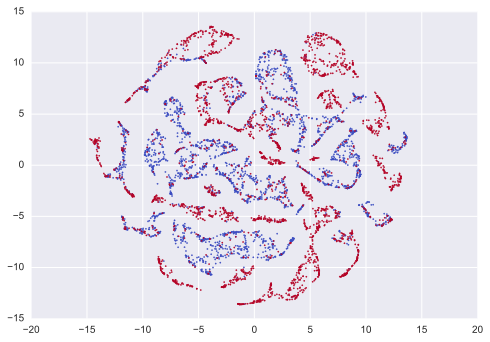

In [66]:
# Plot the t-SNE embedding
plt.figure() 
plt.set_cmap("coolwarm")
plt.scatter(proj[:, 0], proj[:, 1],s=2, c=y, alpha=1, edgecolors='face')

### Evaluating the undersampled models on the test set
However, what really counts is performance on the test set. It's time to load that in, add the features, and then try it out with our trained models.

In [67]:
with open('test_track_info.pickle','r') as f:
	test_track_info = pickle.load(f)
    
with open('test_lyrics_data.pickle','r') as f:
	test_lyrics = pickle.load(f)

In [68]:
new_features = compute_features(test_lyrics, test_track_info.tdm_row)
test_data = pd.concat([test_track_info, new_features],axis=1)
test_data_scaled = scaler.transform(test_data.loc[:,features])  # Use scaler that was fit on train_data

0.0232152144114


First up is SVM. Although the accuracy is still fairly high, and the F1 score is much higher than the no-rap baseline, the accuracy is actually lower, 93.1% vs 95.2%. Furthermore, the F1 score is lower than our cross-validation predicted, and full 46.8% of the songs identified as rap were not rap songs.

In [69]:
# Train SVM on the whole training set
clf = svm.SVC()
fitinfo = clf.fit(train_data_scaled, y)
prediction = clf.predict(test_data_scaled)

examine_prediction(test_data.is_rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	93.1%
Rap songs correctly identified =	86.3%
Songs incorrectly identified as rap =	46.8%
Non-rap songs identified as rap =	6.3%
F1 score =	0.659
Confusion matrix
[[6028  405]
 [  73  461]]


The random forest does even worse, with an at below 90% and even more of the songs identified as rap being misclassified - in fact the majority.

In [70]:
# Just for interest, a random forest
clf = RandomForestClassifier(n_estimators=100)
fitinfo = clf.fit(train_data_scaled, y)
prediction = clf.predict(test_data_scaled)

examine_prediction(test_data.is_rap, prediction, test_data, features, show_misidentified=False)

Accuracy =	90.1%
Rap songs correctly identified =	86.1%
Songs incorrectly identified as rap =	57.3%
Non-rap songs identified as rap =	9.6%
F1 score =	0.571
Confusion matrix
[[5816  617]
 [  74  460]]


Clearly, undersampling so that the dataset is 50/50 non-rap and rap songs biases the detector towards saying it is a rap song, which causes its performance to suffer on the test set, a mixed sample of tracks that contains less than 10% rap songs.
## Imbalanced dataset therapy #2: Training on all data with SVM class weights
Next, I tried another option for imbalanced data sets, using the full training set but weighting the rap tracks a little higher. I focused on SVM, since it is faster than random forest and had some of the best performances.

### No class weighting

Before trying the weighting, however, I decided to just try the whole training set without any class weighting. When I perform a cross-validation, the accuracy is higher, but the F1 score is lower than with the 50/50 trained models. We are only detecting about half of the rap songs.

In [71]:
# Create un-subsampled training set (i.e. all the training data)
un_train_data = track_info.copy()
new_features = compute_features(lyrics, un_train_data.tdm_row)
un_train_data = pd.concat([un_train_data, new_features],axis=1) 

# Cross-validation of SVM on imbalanced data with no class weigthinging.
scaler_un = preprocessing.StandardScaler().fit(un_train_data.loc[:,features])
un_train_data_scaled = scaler_un.transform(un_train_data.loc[:,features])
un_y = un_train_data.is_rap
un_kfold = StratifiedKFold(y, shuffle=True, n_folds=num_folds, random_state=seed)

clf = svm.SVC()

prediction = cross_validation.cross_val_predict(clf, un_train_data_scaled, un_y, cv=un_kfold)

examine_prediction(un_y, prediction, un_train_data, features, show_misidentified=False)

0.223075735569
Accuracy =	96.7%
Rap songs correctly identified =	46.7%
Songs incorrectly identified as rap =	24.0%
Non-rap songs identified as rap =	0.8%
F1 score =	0.579
Confusion matrix
[[52634   398]
 [ 1435  1259]]


### "Balance" class weighting
Adding "balanced" class weighting (where classes are weighted based on the inverse of how often they appear) didn't make things better - although they greatly increased the number of rap songs that were identified as such, they made both accuracy and F1 worse.

In [72]:
# Cross-validation of SVM on unbalanced data with class weightings
clf = svm.SVC(class_weight='balanced')
prediction = cross_validation.cross_val_predict(clf, un_train_data_scaled, un_y, cv=un_kfold)

examine_prediction(un_y, prediction, un_train_data, features, show_misidentified=False)

Accuracy =	92.5%
Rap songs correctly identified =	78.2%
Songs incorrectly identified as rap =	63.1%
Non-rap songs identified as rap =	6.8%
F1 score =	0.501
Confusion matrix
[[49427  3605]
 [  587  2107]]


I had a hunch that finding an intermediate level of class weighting, somewhere between none and balanced, would give me the best possible F1 on the test set. I started by recreating manually the balanced class weightings.

In [73]:
# Recreate the class weightings that 'balanced' produces
cw = len(un_y)/(2. * np.bincount(un_y))
print cw

[  0.53  10.34]


Then I used grid search cross validation to take 10 steps between completely unweighted and weighted, to find the class weights that optimize F1.

In [ ]:
# Search to optimize the class weightings, with 10 steps between no weighting and balanced weighting
from sklearn import grid_search
import time

ratios = np.linspace(float(np.sum(un_y))/len(un_y),0.5,10)
cws = [{0:len(un_y)/(2 * len(un_y)*(1-r)),1:len(un_y)/(2 * len(un_y)*r)} for r in ratios]

#start = time.time()
#param_grid = {'class_weight':cws}
#clf = svm.SVC()
#gs = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, verbose=0, scoring='f1',n_jobs=-1)
#gs.fit(un_train_data_scaled, un_y)
#for params, mean_score, scores in gs.grid_scores_:
#       print("%0.3f (+/-%0.03f) for %r"
#            % (mean_score, scores.std() * 2, params))
#print time.time()-start

```
# Output of the previous cell when uncommented, since it takes too long and produces a lot of ugly warning messages

0.500 (+/-0.015) for {'class_weight': {0: 0.52539975863629507, 1: 10.342613214550854}}
0.596 (+/-0.021) for {'class_weight': {0: 0.55464822314479156, 1: 5.0747141556207627}}
0.625 (+/-0.033) for {'class_weight': {0: 0.58734512237966974, 1: 3.3622090528799751}}
0.636 (+/-0.033) for {'class_weight': {0: 0.62413852322533925, 1: 2.5138792818261102}}
0.637 (+/-0.027) for {'class_weight': {0: 0.66584973394368752, 1: 2.0073886104929475}}
0.638 (+/-0.018) for {'class_weight': {0: 0.71353533858975715, 1: 1.6707664017162922}}
0.631 (+/-0.014) for {'class_weight': {0: 0.76857794369149857, 1: 1.4308284833960971}}
0.618 (+/-0.019) for {'class_weight': {0: 0.83282243735573969, 1: 1.2511512805033203}}
0.599 (+/-0.029) for {'class_weight': {0: 0.90878682013220458, 1: 1.1115657053697283}}
0.573 (+/-0.020) for {'class_weight': {0: 1.0, 1: 1.0}}```

### Evaluating the optimal class-weighted SVM model on test data
Based on the results of the grid search, I chose an intermediate class weighting, where non-rap entries are weighted at 0.71 and rap entries at 1.67, or 2.3 times as much. I then applied the trained SVM model to the test data.

The accuracy was 96.5%, better than the baseline, but more importantly the F1 score was 0.75, much higher than the 0.66 obtained via the undersampling. 68.4% of rap songs were correctly identified as such, with less than 1.2% of non-rap songs mis-identified.

In [75]:
clf = svm.SVC(class_weight=cws[5])
test_data_scaled_un = scaler_un.transform(test_data.loc[:,features]) # Different scaler
fitinfo = clf.fit(un_train_data_scaled, un_y)
prediction = clf.predict(test_data_scaled_un)

examine_prediction(test_data.is_rap, prediction, test_data, features, show_misidentified=True)

Accuracy =	96.5%
Rap songs correctly identified =	68.4%
Songs incorrectly identified as rap =	16.9%
Non-rap songs identified as rap =	1.2%
F1 score =	0.750
Confusion matrix
[[6359   74]
 [ 169  365]]
Misidentified as rap: 


,artist_name,title,mean_word_instances,mean_word_length,median_word_rank,total_num_words
77,Hanna Pakarinen,Superhero,0.005208,4.057292,305.5,464.0
99,Najee,Betcha Don't Know,0.004444,4.191111,418.0,587.0
229,Boomkat,Crazylove,0.006250,4.018750,206.5,567.0
304,Samael,High Above,0.005747,4.511494,251.0,550.0
515,Craig David,What's Changed,0.005848,4.128655,170.0,731.0
592,Mariee Sioux,Wild Eyes,0.006944,4.333333,354.5,369.0
693,Alabama 3,The Night We Nearly Got Busted,0.005495,4.324176,193.0,510.0
761,Brand New,Sic Transit Gloria ... Glory Fades,0.005236,4.439791,220.0,561.0
781,New Edition,Is This The End,0.003021,4.528701,355.0,903.0
929,Merle Travis,I'll See You In My Dreams,0.005495,4.329670,310.0,410.0


Misidentified as nonrap: 


,artist_name,title,mean_word_instances,mean_word_length,median_word_rank,total_num_words
52,Kid Koala,A Night at The Nufonia,0.015385,4.000000,60.0,117.0
84,Articolo 31,Mollami,0.015385,3.384615,745.0,183.0
95,La Excepcion,Hoy Frescuni,0.066667,3.133333,525.0,24.0
154,Orishas,La Calle,0.009346,4.102804,1012.0,256.0
271,Buck 65,Hot Lunch,0.007576,4.590909,327.5,241.0
285,Necro,Portrait of A Death Rapper,0.007812,4.414062,332.5,265.0
296,Articolo 31,Commodore 64 Vs PC,0.023256,3.162791,1273.0,118.0
391,Cypress Hill,I Wanna Get High,0.013514,3.945946,133.0,200.0
403,Amanda Blank,A Love Song,0.005291,4.275132,166.0,516.0
446,Fatty Koo,Princess In Disguise,0.008065,4.225806,282.0,233.0


### Error analysis
The procedure above also outputted some examples of misclassification, and it's interesting to look at these. I see two types of songs that tend to be misclassified as rap: exceptionally wordy ballads, because of the high total_num_words, and foreign-language songs, because of high median_word_rank - because words are represented in terms of their rank in the overall corpus, and the overall corpus appears to be majority English songs, non-English words have a higher average rank. This would seem to be an impediment to building a cross-language classifier with this feature. However, median_word_rank would be a reliable indicator if the training corpus was built with an equal number of tracks for each language, or within only one language. As for the wordy ballads, this could be partially compensated for by including metadata about the track duration - I expect that words per minute would be a more reliable predictor.

As for songs that are misclassified as non-rap, many of these are not in fact rap: the very short total_num_word values, e.g. 29 or 53, indicate that they are in fact primarily instrumental with a spoken word sample, or album skits. And Never Going Back Again by Lindsey Buckingham (of Fleetwood Mac) is labelled as rap, which suggests that there are data quality issues in the initial labelling that are lowering performance scores slightly.

## Conclusion
For a diverse, primarily English-language dataset of lyrics, I achieved 96.5% accuracy in classifying tracks as rap, with an F1 score of 0.75 corresponding to detecting 68.4% of rap songs and misclassifying 1.2% of non-rap songs as rap. Depending on the needs of the application, the model could be biased towards detecting more rap songs, at a cost of misclassfying more non-rap songs. 

I dealt with the problem of imbalanced datasets by using a SVM model with class weights tuned using crossvalidation. This strategy and the performance would change if the composition of the target data were different - for example if it consisted of equal numbers rap and non-rap, we could achieve at least 84% accuracy (above a chance of 50%) with these four superficial text features.

I could achieve even better genre classification based on lyrics by using semantic content, but the current superficial text features - `total_num_words`,  `mean_word_length`, `median_word_rank`, and `mean_word_instances` - are both sufficient and helpful for classifying songs as rap at that performance level, and these features are language and vocabulary independent. So that even when trained on a primarily English-language corpus, most of them could be used to classify Italian-language songs as rap or not.